In [534]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import mne # See docs: https://mne.tools/dev/generated/mne.io.read_raw_edf.html
import pyedflib # See docs: https://pyedflib.readthedocs.io/en/latest/
from pyedflib import highlevel

In [535]:
# Defining the file path as a string for easier use
file_path = '/Users/jacksonpowell/Documents/GitHub/learningML/data_files/sub-01_ses-01_task-musicTherapy_eeg.edf'; 

In [536]:
# "highlevel" takes data from .edf file (see docs in includes) and saves in signals (np.array of numbers) and headers (dicts)
signals, signal_headers, data_header = highlevel.read_edf(file_path); 

# Printing to see data and size
print(signal_headers[0]);  
print(signals[0].shape); 

{'label': 'Fp1', 'dimension': 'uV', 'sample_rate': 1024.0, 'sample_frequency': 1024.0, 'physical_max': 31790000.0, 'physical_min': -3184000.0, 'digital_max': 32767, 'digital_min': -32767, 'prefilter': 'HP:0.0Hz LP:512.0Hz N:NoneHz', 'transducer': ''}
(1378304,)


In [537]:
def plot_signal(signal, header, window, color = None, tag = None):

    if not tag: 
        tag = ""; 

    frequency = header["sample_frequency"]; # Takes frequency value from header dict

    total_time_seconds = len(signal) / frequency; # Storing total time in seconds
    total_time_mins = len(signal) / frequency / 60; # Storing total time in minutes 
    time = np.linspace(0, total_time_seconds, len(signals[0]), endpoint=True); # Creating x-axis based on frequency

    start_time = window[0]; # Taking first value in window array, aka the start of the zoomed frame
    stop_time = window[1]; # Taking second value in window array, aka the end of the zoomed frame

    time_frame = stop_time - start_time; # Total time of zoomed frame
    zoomed_frame = int(time_frame * frequency); # Number of data points in zoomed frame
    zoomed_signal = signal[int(start_time * frequency) : int(stop_time * frequency)]; # Subset of signal plotted
    zoomed_time = np.linspace(start_time, stop_time, zoomed_frame, endpoint=True); # x-axis for zoomed plot

    # Plot specificiations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 4)); 

    ax1.plot(time, signal, color=color); 
    ax1.set_xlabel('time (s)'); 
    ax1.set_ylabel('voltage (uV)'); 
    ax1.set_title(f"total frame, {tag} {header['label']}"); 

    ax2.plot(zoomed_time, zoomed_signal, color=color); 
    ax2.set_xlabel('time (s)'); 
    ax2.set_ylabel('voltage (uV)'); 
    ax2.set_title(f"from {start_time}s to {stop_time}s, {tag} {header['label']}"); 

    plt.show(); 

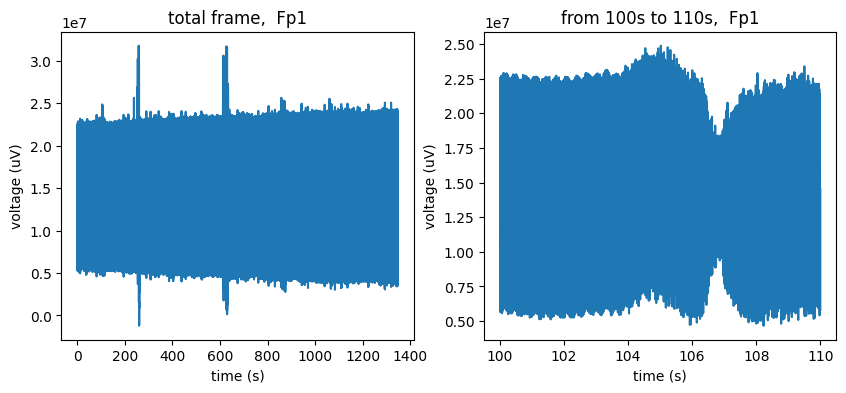

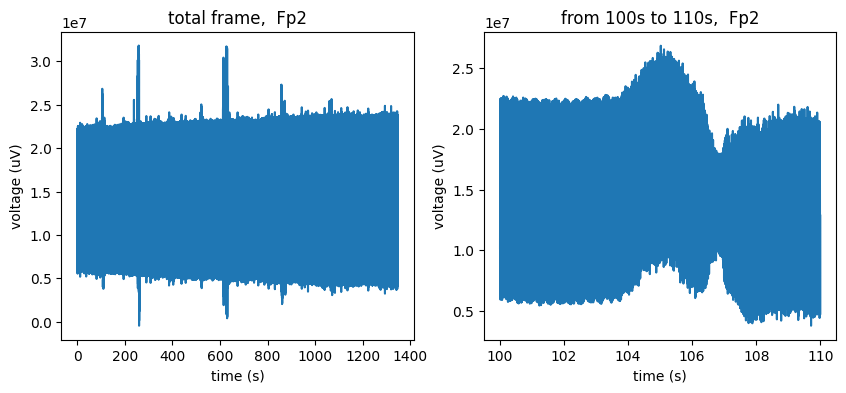

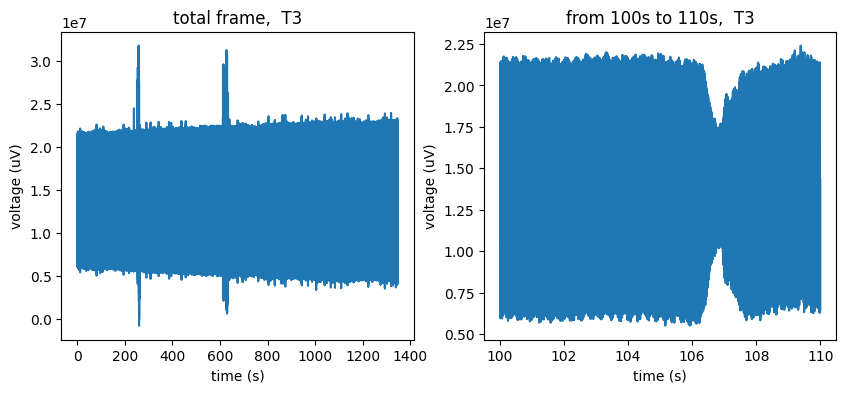

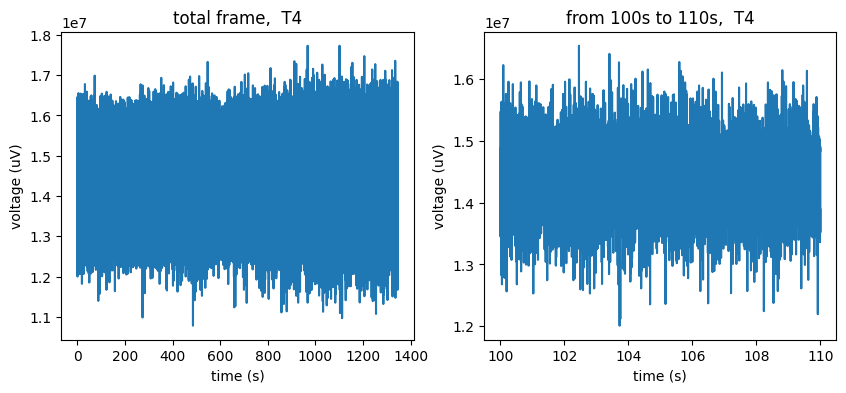

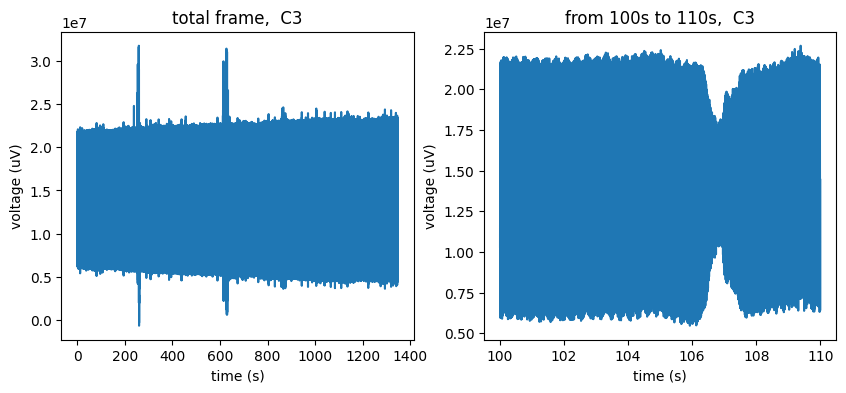

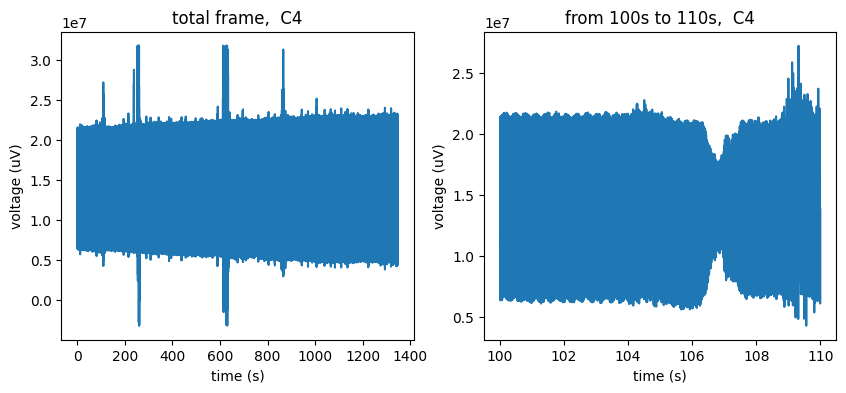

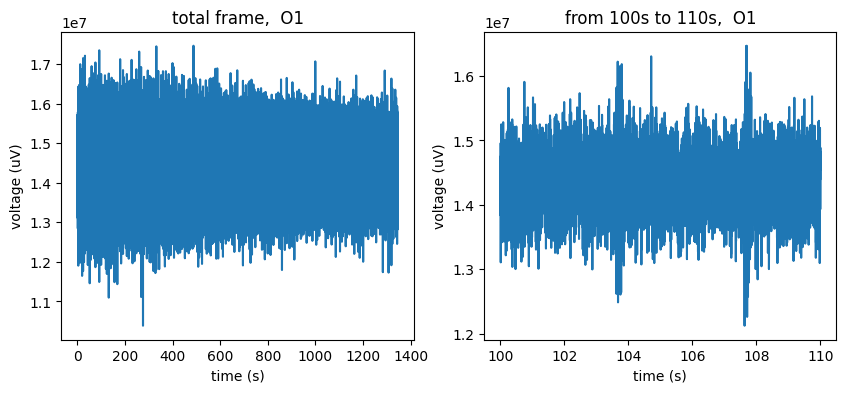

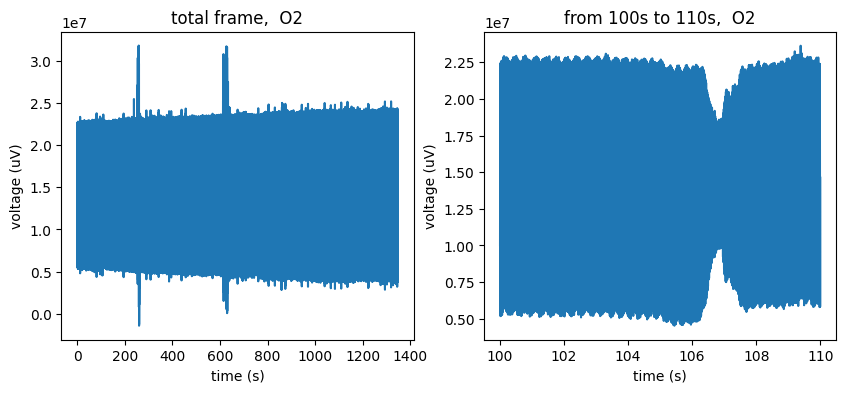

In [538]:
start_time = 100; 
stop_time = 110; 

for i in range(0, len(signal_headers), 1): # Plotting over all electrodes
    # Information is the signal to be plotted, its corresponding header, and then a zoomed in window
    # I.e., if you want to see a zoomed in plot from seconds 0 to 5, the third argument would be [0,5]
    plot_signal(signals[i], signal_headers[i], [start_time, stop_time]); 

In [539]:
from scipy import signal

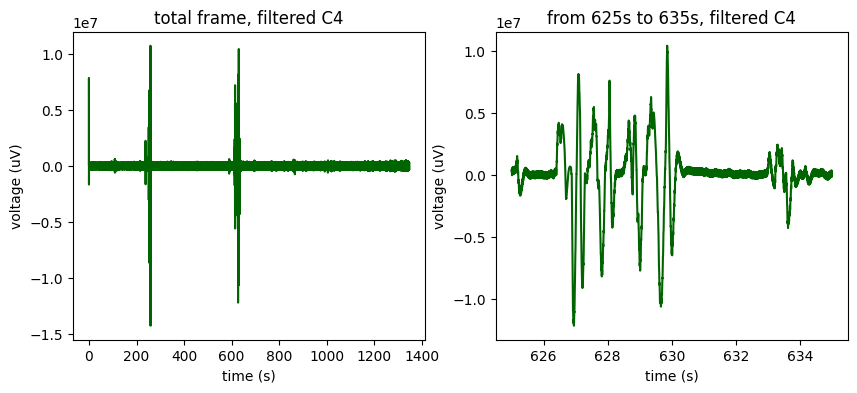

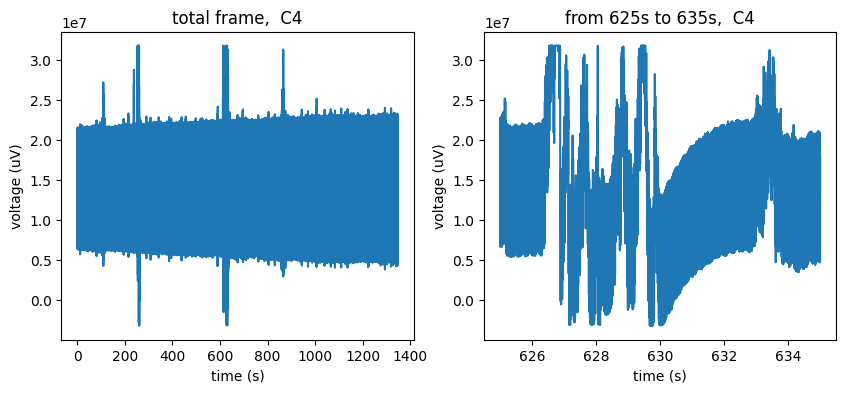

In [540]:
signal_num = 5; # Which
start_time = 625; 
stop_time = 635; 

# Docs: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html
bandpass = signal.butter(1, [2, 5], 'bandpass', fs=1024, output='sos'); 
filtered_signal = signal.sosfilt(bandpass, signals[signal_num]); 

plot_signal(filtered_signal, signal_headers[signal_num], [start_time, stop_time], 'darkgreen', tag = "filtered"); 
plot_signal(signals[signal_num], signal_headers[signal_num], [start_time, stop_time]); 

In [541]:
from scipy.fft import fft, ifft, fftfreq
from scipy.stats import skew, kurtosis

In [553]:
def extractFeatures(signal, header):

    features = {'label' : header['label'], 
                'mean' : 0, 
                'std_dev': 0,
                'skewness' : 0,
                'kurt' : 0, 
                'dominant_freq' : 0}

    features['mean'] = np.mean(signal); 
    features['std_dev'] = np.std(signal); 
    features['skewness'] = skew(signal); 
    features['kurt'] = kurtosis(signal); 

    normalized_signal = (signal - np.mean(signal)) / np.std(signal)

    N = len(signal); 
    delta_t = 1 / header['sample_frequency']; 

    fft_values = fft(normalized_signal); 
    freq_domain = np.fft.fftfreq(N, d = delta_t); 

    fft_magnitude = np.abs(normalized_signal); 

    print(np.argmax(fft_magnitude)); 
     
    features['dominant_freq'] = freq_domain[np.argmax(fft_magnitude)]; 

    # I don't really understand what // does but every online resource uses this 
    plt.plot(freq_domain[:N//2], abs(fft_values[0:N//2])); 
    plt.xlabel('freq (hz)'); 
    plt.title(f"{features['label']}, dom_freq = {round(features['dominant_freq'], 2)} hz"); 
    plt.show(); 

    print(features); 

264505


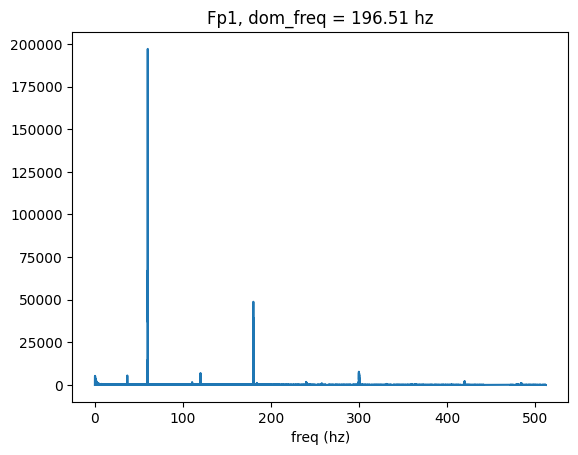

{'label': 'Fp1', 'mean': 14350207.314645413, 'std_dev': 5050612.777719861, 'skewness': -0.15062924055470017, 'kurt': -0.5356172739824374, 'dominant_freq': 196.51188707280832}
264504


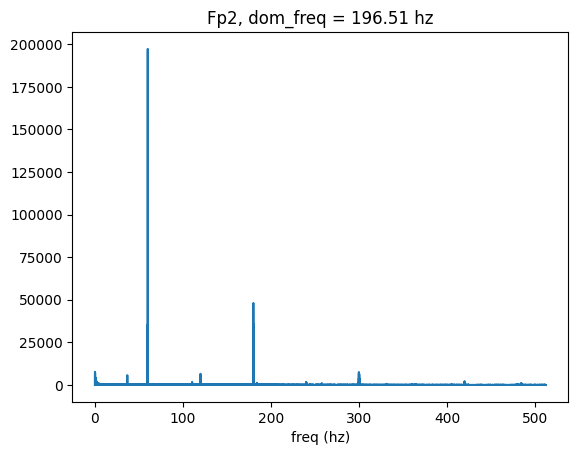

{'label': 'Fp2', 'mean': 14350413.173348809, 'std_dev': 4944182.571176132, 'skewness': -0.13692835686764598, 'kurt': -0.5500849439120024, 'dominant_freq': 196.5111441307578}
264505


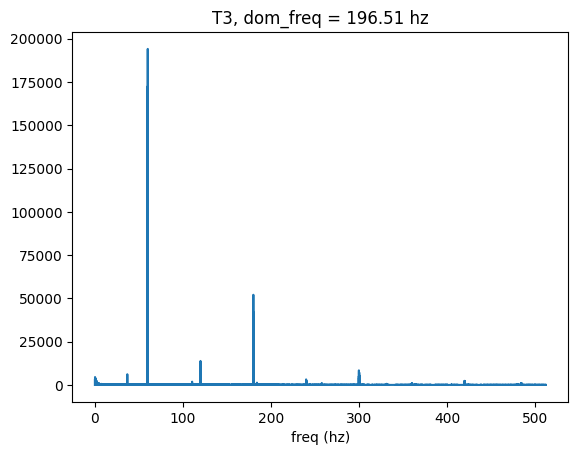

{'label': 'T3', 'mean': 14350000.631209327, 'std_dev': 4602850.346021919, 'skewness': -0.3106091008140815, 'kurt': -0.45820316769784286, 'dominant_freq': 196.51188707280832}


In [554]:
for i in range(0, len(signal_headers), 1):
    extractFeatures(signals[i], signal_headers[i]); 